In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from time import time
import threading
from concurrent.futures import ThreadPoolExecutor
import pickle

import tensorflow as tf
import numpy as np
from PIL import Image
from glob import glob
import bcolz
from bcolz_array_iterator import BcolzArrayIterator

from keras.models import Model
from keras.layers import Layer, Input, InputSpec, Lambda, Convolution2D, BatchNormalization, Activation, UpSampling2D, merge
import keras.backend as K

def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

def plots(ims, figsize=(12,6), rows=1, cols=1, interp=None, titles=None, cmap=None):
    fig = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = fig.add_subplot(rows, cols, i+1)
        if titles:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=interp, cmap=cmap)
        plt.axis('off')

from vgg16_avg import VGG16_Avg
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

Using TensorFlow backend.


# Preprocess the data

In [2]:
def _resize(img):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_size/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

def resize_img(i):
    img = Image.open(filenames[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: return
    return _resize(img)

def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    tl.place[:] = (np.array(r)[get_slice(r.size[1], new_size), get_slice(r.size[0], new_size)] 
        if r else 0.)
    arr.append(tl.place)

## Content images

In [30]:
start = time()

filenames = glob("data/imagenet/n*/*.JPEG")
filenames = np.random.permutation(filenames)
pickle.dump(filenames, open("data/imagenet_20k_random_filenames.pkl", "wb"))
filenames = pickle.load(open("data/imagenet_20k_random_filenames.pkl", "rb"))

new_size = 64
new_shape = (new_size, new_size, 3)
bc_path = "data/imagenet_20k_random_64x64.bc"
# memory locality:
arr = bcolz.carray(np.empty((0,)+new_shape, 'float32'), 
                   chunklen=1, mode='w', rootdir=bc_path)

# parallel processing:
tl = threading.local()
tl.place = np.zeros(new_shape, "uint8")
step = 6400
n = len(filenames)
for i in range(0, n, step):
    with ThreadPoolExecutor(max_workers=16) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res: app_img(r)
    arr.flush()

print(time() - start)

26.610724687576294


19439


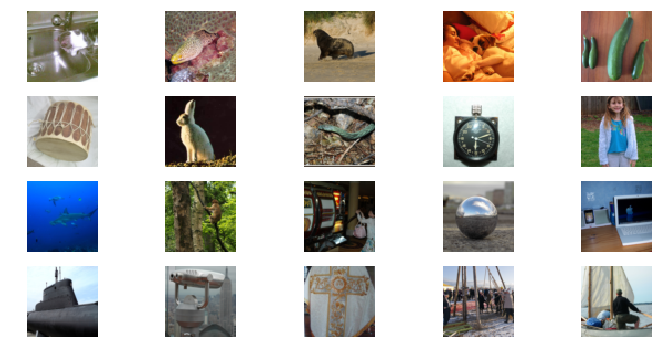

In [31]:
arr2 = bcolz.open(bc_path)[:].astype('uint8')
print(len(arr2))
plots(arr2[:20], figsize=(12,6), rows=4, cols=5)

## Style images

In [3]:
filenames = glob("data/art/*")

new_size = 64
new_shape = (new_size, new_size, 3)
bc_path = "data/art_64x64.bc"
# memory locality:
arr = bcolz.carray(np.empty((0,)+new_shape, 'float32'), 
                   chunklen=20, mode='w', rootdir=bc_path)

# parallel processing:
tl = threading.local()
tl.place = np.zeros(new_shape, "uint8")
step = 6400
n = len(filenames)
for i in range(0, n, step):
    with ThreadPoolExecutor(max_workers=16) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res: app_img(r)
    arr.flush()

24


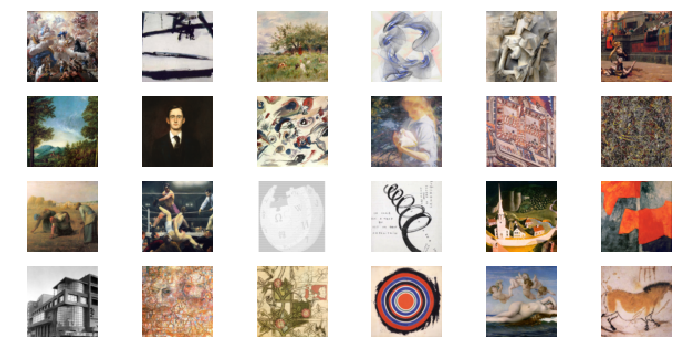

In [15]:
bc_path = "data/art_64x64.bc"
arr2 = bcolz.open(bc_path)[:].astype('uint8')
print(len(arr2))
plots(arr2, figsize=(12,6), rows=4, cols=6)

## Concatenations

In [16]:
def concatenate(i):
    concatenations = []
    content = content_bc[i]
    for j in range(len(style_bc[:-4])):
        style = style_bc[j]
        concatenation = np.concatenate([content, style], axis=2)
        concatenations.append(concatenation)
    return concatenations

def append_concat(concat):
    tl.place[:] = np.array(concat)
    arr.append(tl.place)

In [17]:
start = time()

content_bc = bcolz.open("data/imagenet_20k_random_64x64.bc")
style_bc = bcolz.open("data/art_64x64.bc")

new_size = 64
new_shape = (new_size, new_size, 6)
bc_path = "data/concatenations_64x64x6.bc"
# memory locality:
arr = bcolz.carray(np.empty((0,)+new_shape, 'float32'), 
                   chunklen=20, mode='w', rootdir=bc_path)

# parallel processing:
tl = threading.local()
tl.place = np.zeros(new_shape, "uint8")
step = 6400
n = len(content_bc)
for i in range(0, n, step):
    with ThreadPoolExecutor(max_workers=16) as execr:
        res = execr.map(concatenate, range(i, min(i+step, n)))
        for concats in res:
            for concat in concats:
                append_concat(concat)
    arr.flush()
    
print(time() - start)

75.80503296852112


388780


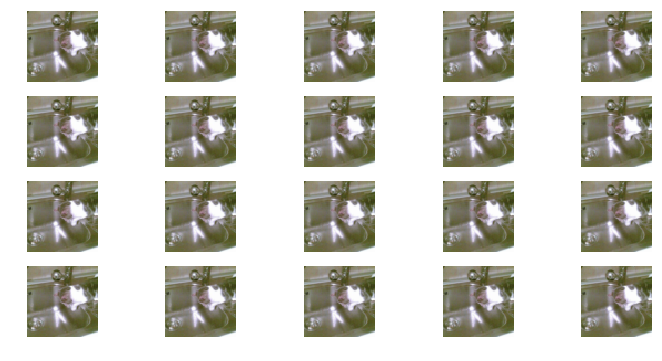

In [18]:
bc_path = "data/concatenations_64x64x6.bc"
arr2 = bcolz.open(bc_path)
print(len(arr2))
imgs = [img[:, :, :3].astype('uint8') for img in arr2[:20]]
plots(imgs, figsize=(12,6), rows=4, cols=5)

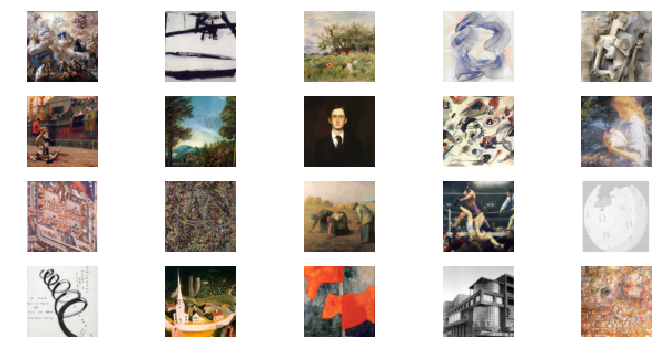

In [19]:
imgs = [img[:, :, 3:6].astype('uint8') for img in arr2[:20]]
plots(imgs, figsize=(12,6), rows=4, cols=6)

# Block definitions

In [2]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

def gram_matrix_batch(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

def mean_sq_batch(diff): 
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

def get_output(model, i): return model.get_layer(f'block{i}_conv2').output

w=[0.1, 0.2, 0.6, 0.1]
def loss_constructor(analyses):
    loss = 0
    n = len(analyses)//3
    combined = analyses[:n]
    content = analyses[n:2*n]
    style = analyses[2*n:3*n]
    for i in range(n):
        loss += mean_sq_batch(combined[i] - content[i]) * w[i]
        loss += mean_sq_batch(gram_matrix_batch(content[i]) - gram_matrix_batch(style[i])) / 2.
    return loss

# Model definitions

In [3]:
def make_combiner(combiner_input):
    c = 2 # Number of conv blocks and up blocks
    r = 5 # Number of res blocks
    r2 = r * 8 # Amount of reflection padding
    x = ReflectionPadding2D((r2, r2))(combiner_input)
    x = conv_block(x, 64, 9, (1,1))
    for i in range(c): x = conv_block(x, 64, 3)
    for i in range(r): x = res_crop_block(x, 64)
    for i in range(c): x = up_block(x, 64, 3)
    x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    combiner_output = Lambda(lambda x: (x+1)*127.5)(x)
    return Model(combiner_input, combiner_output)

def make_analyzer(analyzer_input):
    vgg = VGG16_Avg(include_top=False, input_tensor=Lambda(preproc)(analyzer_input))
    for l in vgg.layers: l.trainable=False
    analyzer_output = [get_output(vgg, i) for i in [2, 3, 4, 5]]
    return Model(analyzer_input, analyzer_output)

def make_loss_calculator(loss_calculator_input, analyses):
    loss_calculator_output = Lambda(loss_constructor)(analyses)
    return Model(loss_calculator_input, loss_calculator_output)

# Make models

In [4]:
content_path = "data/imagenet_20k_random_64x64.bc"
style_path = "data/art_64x64.bc"
concatenation_path = "data/concatenations_64x64x6.bc/"

content_bc = bcolz.open(content_path)
styles = bcolz.open(style_path)[:-4]
concatenation_bc = bcolz.open(concatenation_path)

nb_content_images = len(content_bc)
nb_styles = len(styles)
nb_concatenations = len(concatenation_bc)

shape3 = content_bc[0].shape
shape6 = concatenation_bc[0].shape

In [5]:
# Combiner
combiner_input = Input(shape6)
combiner = make_combiner(combiner_input)
combiner_output = combiner(combiner_input)

# Analyzer
analyzer_input = Input(shape3)
analyzer = make_analyzer(analyzer_input)
analyzer_content_input = Input(shape3)
analyzer_style_input = Input(shape3)
analysis_of_combiner_img = analyzer(combiner_output)
analysis_of_content_img = analyzer(analyzer_content_input)
analysis_of_style_img = analyzer(analyzer_style_input)
analyses = analysis_of_combiner_img+analysis_of_content_img+analysis_of_style_img

# Loss calculator
loss_calculator_input = [combiner_input, analyzer_content_input, analyzer_style_input]
loss_calculator = make_loss_calculator(loss_calculator_input, analyses)
loss_calculator.compile("adam", "mae")

Loss: 283	Examples seen: 2000	Batches seen: 100	Time since last print: 14 sec.	 Total time: 14 sec.


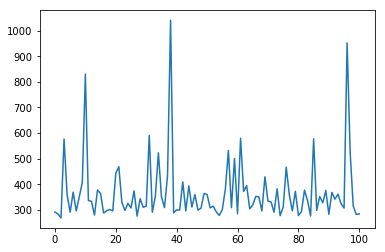

Loss: 294	Examples seen: 4000	Batches seen: 200	Time since last print: 14 sec.	 Total time: 28 sec.


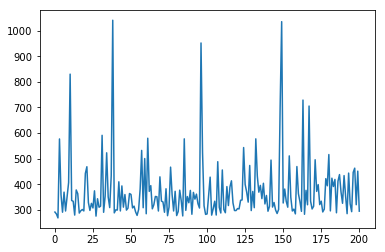

Loss: 265	Examples seen: 6000	Batches seen: 300	Time since last print: 14 sec.	 Total time: 43 sec.


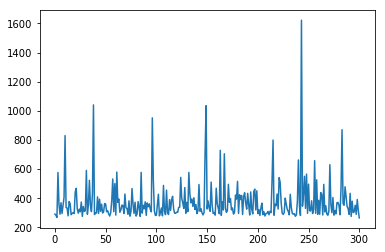

Loss: 319	Examples seen: 8000	Batches seen: 400	Time since last print: 14 sec.	 Total time: 57 sec.


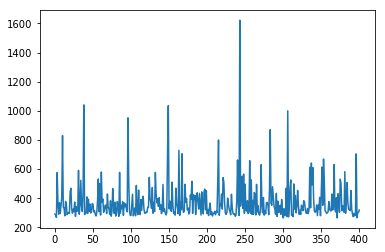

Loss: 351	Examples seen: 10000	Batches seen: 500	Time since last print: 14 sec.	 Total time: 72 sec.


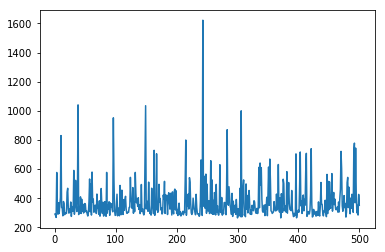

Loss: 340	Examples seen: 12000	Batches seen: 600	Time since last print: 14 sec.	 Total time: 86 sec.


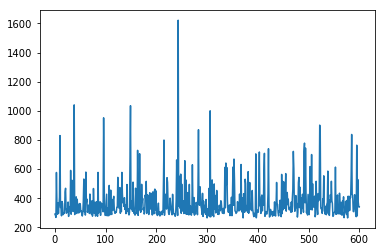

Loss: 269	Examples seen: 14000	Batches seen: 700	Time since last print: 14 sec.	 Total time: 101 sec.


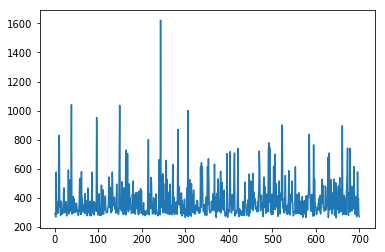

Loss: 409	Examples seen: 16000	Batches seen: 800	Time since last print: 14 sec.	 Total time: 115 sec.


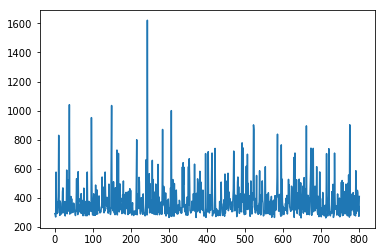

Loss: 314	Examples seen: 18000	Batches seen: 900	Time since last print: 14 sec.	 Total time: 130 sec.


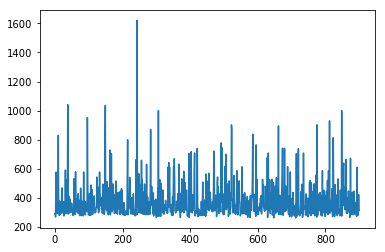

Loss: 378	Examples seen: 20000	Batches seen: 1000	Time since last print: 14 sec.	 Total time: 144 sec.


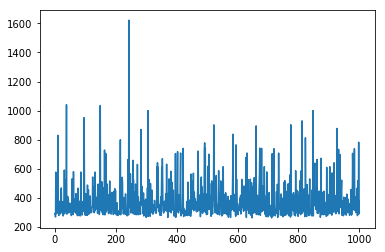

Loss: 364	Examples seen: 22000	Batches seen: 1100	Time since last print: 14 sec.	 Total time: 159 sec.


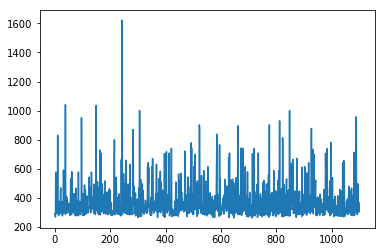

Loss: 285	Examples seen: 24000	Batches seen: 1200	Time since last print: 14 sec.	 Total time: 173 sec.


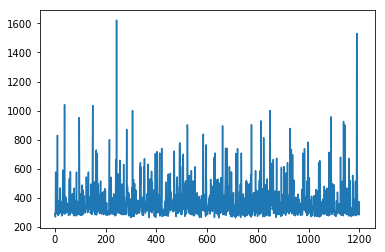

Loss: 288	Examples seen: 26000	Batches seen: 1300	Time since last print: 14 sec.	 Total time: 188 sec.


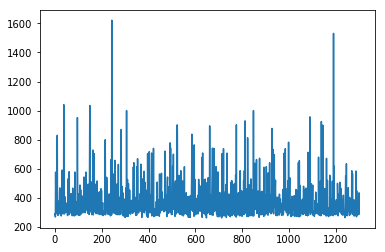

Loss: 385	Examples seen: 28000	Batches seen: 1400	Time since last print: 14 sec.	 Total time: 203 sec.


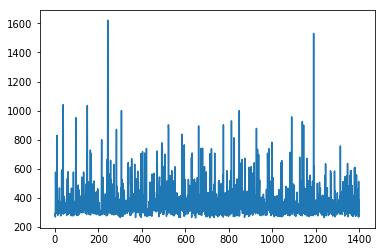

Loss: 470	Examples seen: 30000	Batches seen: 1500	Time since last print: 14 sec.	 Total time: 217 sec.


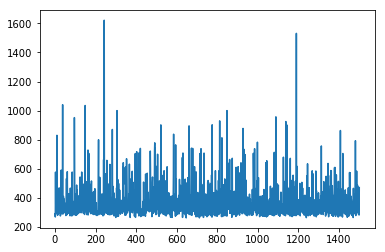

Loss: 323	Examples seen: 32000	Batches seen: 1600	Time since last print: 14 sec.	 Total time: 232 sec.


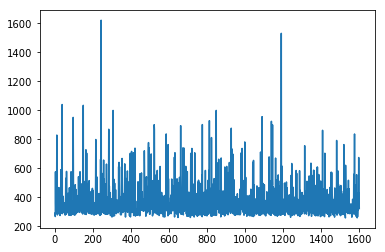

Loss: 320	Examples seen: 34000	Batches seen: 1700	Time since last print: 14 sec.	 Total time: 246 sec.


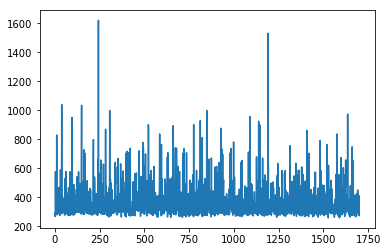

Loss: 315	Examples seen: 36000	Batches seen: 1800	Time since last print: 14 sec.	 Total time: 261 sec.


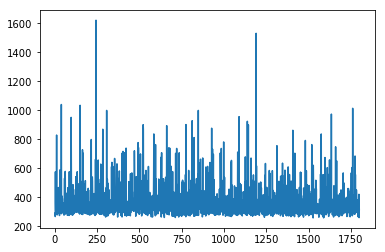

Loss: 337	Examples seen: 38000	Batches seen: 1900	Time since last print: 14 sec.	 Total time: 275 sec.


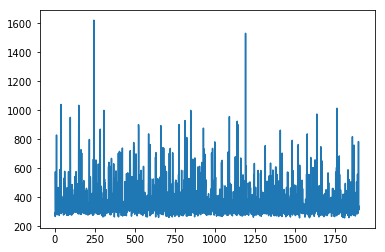

Loss: 297	Examples seen: 40000	Batches seen: 2000	Time since last print: 14 sec.	 Total time: 290 sec.


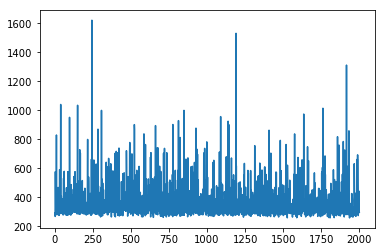

Loss: 310	Examples seen: 42000	Batches seen: 2100	Time since last print: 14 sec.	 Total time: 304 sec.


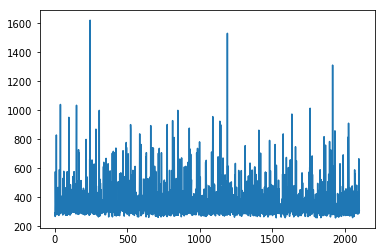

Loss: 305	Examples seen: 44000	Batches seen: 2200	Time since last print: 14 sec.	 Total time: 319 sec.


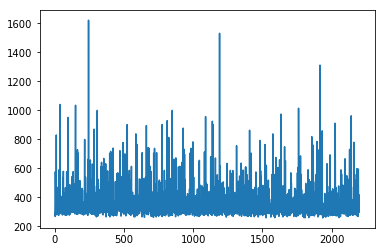

Exception: Probably a KeyBoardInterrupt
CPU times: user 2min 56s, sys: 1min 26s, total: 4min 22s
Wall time: 5min 25s


In [8]:
def train(batch_size, nb_batches):
    losses = []
    targets = np.zeros((batch_size, 1))
    content_iter = BcolzArrayIterator(content_bc, batch_size=1)
    concatenation_iter = BcolzArrayIterator(concatenation_bc, batch_size=batch_size)
    try:
        start0 = time()
        start = start0
        for i in range(nb_batches):
            content = next(content_iter)[:]
            content = np.repeat(content, batch_size, axis=0)
            concatenation = next(concatenation_iter)[:]
            loss = loss_calculator.train_on_batch([concatenation, content, styles], targets)
            losses.append(loss)
            if i % 100 == 0 and i != 0:
                variables = (loss, i*batch_size, i, int(time() - start), int(time() - start0))
                display = "Loss: %d\tExamples seen: %d\tBatches seen: "
                display += "%d\tTime since last print: %d sec.\t Total time: %d sec."
                print(display % variables)
                plt.plot(losses);
                plt.show()
                start = time()
    except (Exception, KeyboardInterrupt) as e:
        e = str(e)
        if not e:
            e = "Probably a KeyBoardInterrupt"
        print("Exception: %s" % e)
        return losses
    return losses
%time losses = train(nb_styles, nb_content_images)

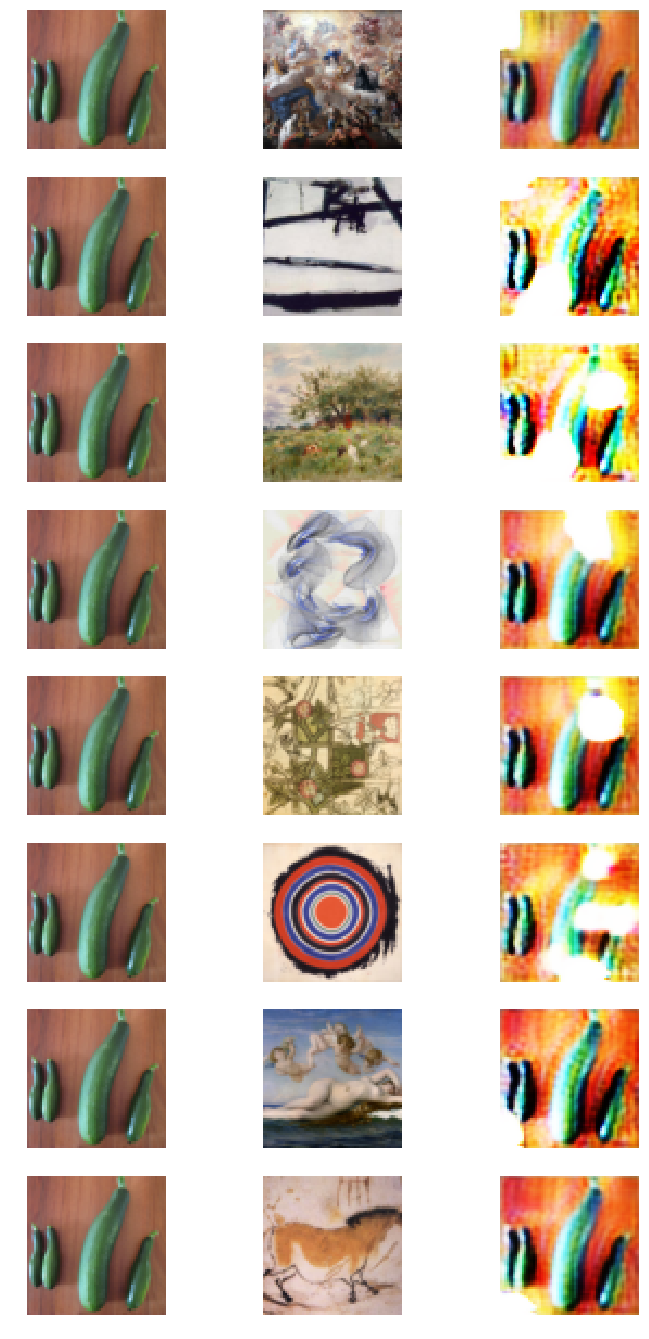

In [7]:
content = content_bc[4]
all_styles = bcolz.open(style_path)
seen_styles = all_styles[:4]
unseen_styles = all_styles[-4:]
selected_styles = np.concatenate([seen_styles, unseen_styles], axis=0)

imgs = []
for style in selected_styles:
    concatenation = np.concatenate([content, style], axis=2)
    concatenations = np.expand_dims(concatenation, 0)
    combinations = combiner.predict(concatenations)
    combination = combinations[0]
    imgs += [content.astype("uint8"), style.astype("uint8"), combination.astype("uint8")]
plots(imgs, figsize=(12, 24), rows=len(selected_styles), cols=3)